In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
import scipy.stats as stats
import seaborn as sns; sns.set_context('notebook')
figsize=(45,10)
from IPython.core.pylabtools import figsize
figsize(14.5,6.5)
from sklearn import linear_model



# Linear Bandit Solver

### Bayesian Linear Regression


(array([ 30.55003327,  29.19410571,  41.30032292,  37.156326  ,
         77.74087279,  58.75089192,  87.89734292,  34.45449934,
         85.61036867,  50.39699043]),
 array([ 30.55003327,  29.19410571,  41.30032292,  37.156326  ,
         77.74087279,  58.75089192,  87.89734292,  34.45449934,
         85.61036867,  50.39699043]))

C:\Users\Trost\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


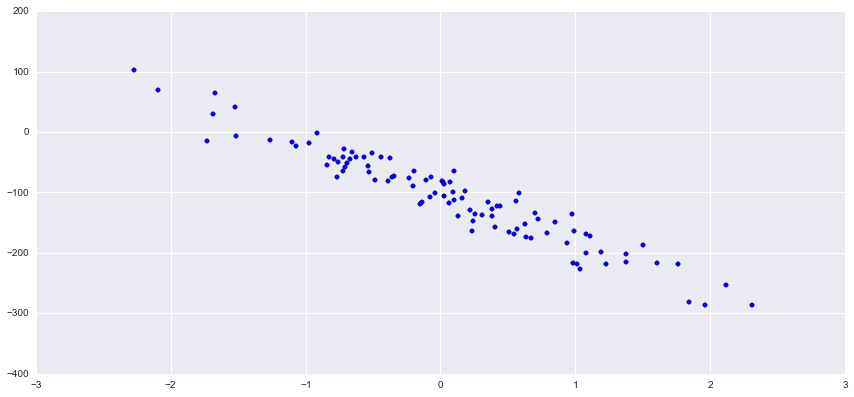

In [4]:
num_features = 1
num_data = 100

from sklearn.datasets import make_regression 

X1 = np.atleast_2d(np.linspace(0,1,num_data)).T

np.random.shuffle(X1)
def evaluate(X):
    return  X*100  + np.random.normal(0,1)
y1 = []
for i in range(num_data):
    y1 += [evaluate(X1[i,:])]
y1 = np.array(y1).flatten()

X,y,coef = make_regression(num_data,num_features,noise   = 20,shuffle=False,coef =True)
y += 100
plt.scatter(X,-y)
y = -y*2
X = X1
y = y1

#X.shape,X1.shape,y.shape,y1.shape,type(X),type(X1),(X+X1).shape,type(y),type(y1),(y+y1).shape
#X[:10],X1[:10]
y[:10],y1[:10]

In [5]:
class BayesReg(object):
    def __init__(self,num_features,alpha = 1,beta = 1):
        self.num_features = num_features
        self.B = np.eye(self.num_features+1)*alpha
        self.Binv = np.linalg.inv(self.B)
        self.f = np.zeros(num_features+1)
        #self.f = self.f.T
        self.mu = 1
        self.beta = beta
        
    def add_intercept(self,X):
        try:
            X.shape[1]
        except:
            X = np.atleast_2d(X)
        X_new = np.ones((X.shape[0],X.shape[1]+1),dtype=X.dtype)
        X_new[:,1:] = X[:,:]
        return np.atleast_2d(X_new[0])
    
    def add_intercept2(self,X):
        try:
            X.shape[1]
        except:
            X = np.atleast_2d(X)
        X_new = np.ones((X.shape[0],X.shape[1]+1),dtype=X.dtype)
        X_new[:,1:] = X[:,:]
        return X_new[0]
    
    
    def observe_x(self,x,y):
        x = self.add_intercept(x)
        #print(np.outer(x,x))
        self.B = self.B + np.outer(x,x)
        self.Binv = np.linalg.inv(self.B)
        #self.Binv = 1/self.B 
        #self.f = self.f + np.dot(x,y)
        #print(x*y)
        #print(np.dot(x,y))
        self.f = self.f + x*y
        self.mu += np.dot(self.Binv,self.f.T)
        #print(self.mu)
        #self.mu += self.Binv * self.f
    
        
    def train(self,X,y,shuffle = True):
        index = list(range(X.shape[0]))
        if shuffle ==True:
            np.random.shuffle(index)
        for i in index:
            self.observe_x(X[i],y[i])

    def predict(self,X):
        """predicts ML estimate (non bayesian)"""
        pred_list = []
        for i in range(X.shape[0]):
            pred_list += [np.sum(self.mu.dot(self.add_intercept(X[i])))]
            
        return np.array(pred_list)
    
    def sx(self,x):
        x = self.add_intercept(x)
        return np.sqrt(1/self.beta + 
                       x.dot(self.Binv).dot(x.T))
    
    def mx(self,x,N=1):
        x = self.add_intercept(x)
        x_Binv = self.Binv.dot(self.mu)
        return self.beta*N*x.dot(x_Binv)
    
    def predict_dist(self,X):
        sx = []
        mx = []
        for i in range(X.shape[0]):
            sx += [self.sx(X[i])]
            mx += [self.mx(X[i])]
        sx = np.asarray(sx)
        mx = np.asarray(mx)
        return mx,sx
    
    def draw(self,num=1):
        w = []
        self.mu = self.beta*self.Binv.dot(self.mu)

        for i in range(num):
            w += [stats.multivariate_normal.rvs(self.mu.flatten(),self.Binv)]
        return w
        
        
        

In [6]:
test = BayesReg(num_features,alpha = 1,beta = 1)
test.add_intercept(1)

array([[1, 1]])

In [7]:
test.train(X,y)

In [8]:
test.mu

array([[ 1124.14819641],
       [ 7571.85631045]])

In [9]:
lin = np.linspace(min(X)*2,max(X)*2,100)#(-3,3,100)#
num_draws = 10

m,s = test.predict_dist(lin)
w = test.draw(num=num_draws)
#m = m.flatten()
#s = s.flatten()

ValueError: x and y can be no greater than 2-D

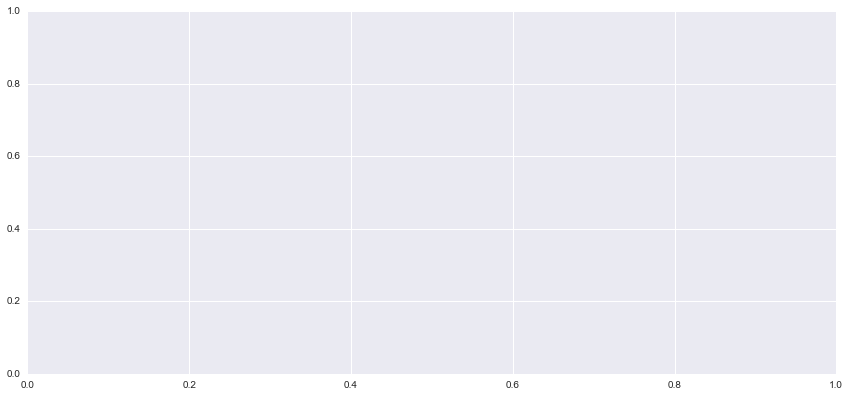

In [10]:
exponent = 10
plt.plot(lin,m,color='red',linewidth = 3,label='predictive Mean')
#plt.plot(X,y,'x')
plt.scatter(X,y,color='black',label='data')
for i in range(num_draws-1):
    plt.plot(lin,lin*w[i+1][1]+w[i+1][0],color='cyan',alpha = (np.log(num_draws)+1)/num_draws)
plt.plot(lin,lin*w[0][1]+w[0][0],color='cyan',alpha = (np.log(num_draws)+1)/num_draws,label = 'draws')

plt.plot(lin,m - s**exponent,'blue',linewidth = 3,label='uncertainty')
plt.plot(lin,m + s**exponent,'blue',linewidth = 3)

plt.legend()
plt.fill_between(lin,m,m- s**exponent,alpha = .3)
plt.fill_between(lin,m,m + s**exponent,alpha = .3)

lin.shape, m.shape, s.shape

C:\Users\Trost\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


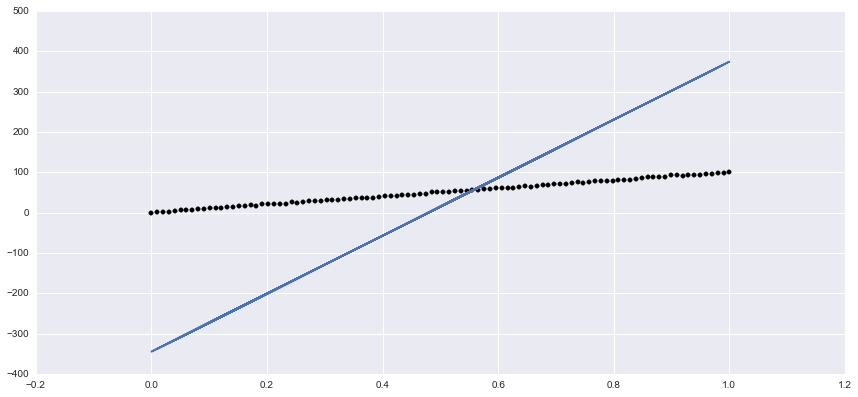

In [11]:
plt.plot(X,test.mu[0]+test.mu[1]*X)
plt.scatter(X,y,color='black',label='data')


In [12]:
regr = linear_model.LinearRegression()

In [13]:
regr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

C:\Users\Trost\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


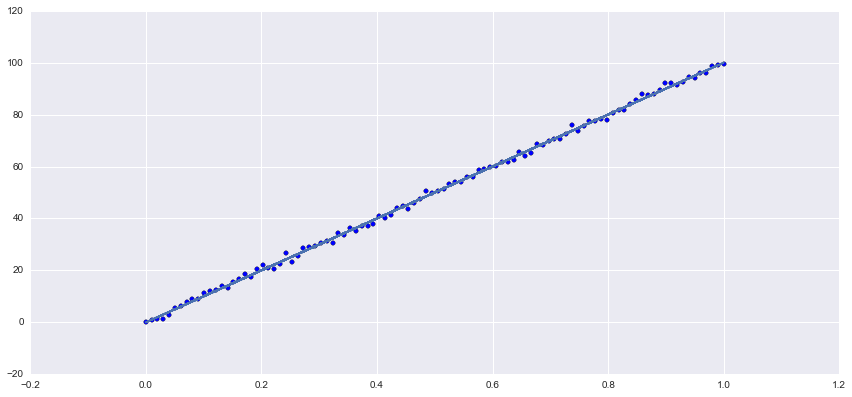

In [14]:
plt.plot(X,regr.predict(X))
plt.scatter(X,y)